In [1]:
import os
import shutil

import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
font = {'size': 16}
matplotlib.rc('font', **font)
from scipy.stats import norm, skewnorm, gamma
import torch
import random

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from gefcom_koopman import GEFComKoopman
from model_objs import ConwayMaxwellPoissonNLL, PoissonNLL
import vanilla_benchmark

In [4]:
data_directory = '..\..\Documents\\2021_winter\AMATH582\AMATH-582\\allenSDK\ecephys_cache' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [6]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

Total number of sessions: 58


In [7]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


In [8]:
session_id = 715093703  # based on the above filter
session = cache.get_session_data(session_id)

In [9]:
units = cache.get_units()

In [10]:
unit_ids = units[(units.ecephys_structure_acronym=="VISp") & (units.specimen_id==filtered_sessions.specimen_id[session_id])].index
unit_ids.shape

(60,)

# Get natural movie data

In [11]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_movie_one"]
stim = session.get_stimulus_table(['natural_movie_one'])
stim_pres_ids = stim.index

In [12]:
stim

,contrast,frame,orientation,size,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
22000,1,0,0,"[1920.0, 1080.0]",2835.861733,4,natural_movie_one,2835.895094,0.033361,3887
22001,1,1,0,"[1920.0, 1080.0]",2835.895094,4,natural_movie_one,2835.928455,0.033361,3888
22002,1,2,0,"[1920.0, 1080.0]",2835.928455,4,natural_movie_one,2835.961816,0.033361,3889
22003,1,3,0,"[1920.0, 1080.0]",2835.961816,4,natural_movie_one,2835.995178,0.033361,3890
22004,1,4,0,"[1920.0, 1080.0]",2835.995178,4,natural_movie_one,2836.028539,0.033361,3891
...,...,...,...,...,...,...,...,...,...,...
66111,1,895,0,"[1920.0, 1080.0]",7994.020482,12,natural_movie_one,7994.053842,0.033360,4782
66112,1,896,0,"[1920.0, 1080.0]",7994.053842,12,natural_movie_one,7994.087202,0.033360,4783
66113,1,897,0,"[1920.0, 1080.0]",7994.087202,12,natural_movie_one,7994.120563,0.033360,4784


In [13]:
times = session.presentationwise_spike_times(stimulus_presentation_ids=stim_pres_ids,
                                             unit_ids=unit_ids)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [14]:
num_presentations = 10
num_bins = 1000 * num_presentations
stim_length = 30  # seconds for natural movie one
# stim_length = 120  # seconds for natural movie three
start_time = stim.iloc[0].start_time
end_time = start_time + stim_length * num_presentations
stim_range = np.array([start_time, end_time])
possible_times = times.iloc[(start_time <= times.index) & (times.index < end_time)]

responses = np.zeros((num_bins, len(unit_ids)))
bin_edges = np.linspace(0, stim_length * num_presentations, num_bins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]

for j, unit_id in enumerate(unit_ids):
    times_j = possible_times[possible_times.unit_id==unit_id].index
    responses[:, j] = np.histogram(times_j, num_bins, range=stim_range)[0]
#     # 1st block where nat 1 is shown, it is shown 10 times in each block
#     presentations1 = stim_epochs.iloc[0].start_time + np.linspace(0, stim_epochs.iloc[0].duration, 10)
#     # 2nd block
#     presentations2 = stim_epochs.iloc[1].start_time + np.linspace(0, stim_epochs.iloc[1].duration, 10)
#     presentations = np.concatenate([presentations1, presentations2])
#     for i, start in enumerate(presentations):
#         times_ij = times[(times.unit_id==unit_id) & (start < times.index) & (times.index < (start + stim_length))].index
#         unit_counts, _ = np.histogram(times_ij, num_bins, range=start + stim_range)
#         trials[i, :, j] = unit_counts

In [15]:
avg_resp = responses.mean(axis=1)
avg_resp_c = avg_resp - avg_resp.mean(axis=0, keepdims=True)

<IPython.core.display.Javascript object>


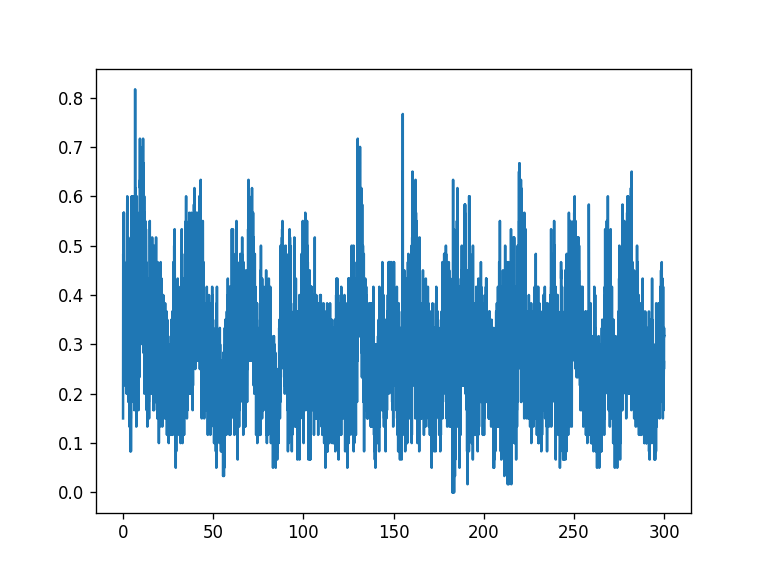

In [16]:
%matplotlib notebook
plt.plot(bin_centers, avg_resp)

In [26]:
stim_range

array([2835.86173294, 3135.86173294])

# Run koopman analysis

In [18]:
unit_idx = 27
x = responses[:, unit_idx].reshape(-1, 1)
x.shape

(10000, 1)

In [19]:
x_original = x
# rnge = np.max(x, axis=0) - np.min(x, axis=0)
# x = x / np.matlib.repmat(rnge, x.shape[0], 1)
# print("x", x.shape)

In [20]:
x.min()

0.0

In [21]:
data_name = f"neuralCell{unit_idx}Nat1[Poisson]"  # TODO: change

train_through = 10000
train_start = 0
delay = 0
test_length = 5000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [5,]
num_fourier = 5
hard_code = [x.shape[0] / num_presentations]
print("x", x.shape)
print("xt", xt.shape)

x (10000, 1)
xt (10000, 1)


In [22]:
model = PoissonNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [23]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([1111.1111,  250.0000,  500.0000,  333.3333,  999.9999],
       dtype=torch.float64)


tensor([0.0057, 0.0251, 0.0126, 0.0188, 0.0063], dtype=torch.float64)

In [24]:
k.fit(xt, iterations=100, interval=10, verbose=True, cutoff=0, weight_decay=0, lr_theta=1e-4, lr_omega=1e-6);

Iteration  0
tensor([1111.1111,  250.0000,  500.0000,  333.3334,  999.9999])
Setting periods to tensor([1111.0934,  250.0043,  500.0167,  333.3569,  999.8651],
       grad_fn=<MulBackward0>)
Loss:  1.5809798783812892
Iteration  1
tensor([1111.0934,  250.0043,  500.0167,  333.3569,  999.8651])
Setting periods to tensor([1111.0747,  250.0085,  500.0325,  333.3800,  999.7356],
       grad_fn=<MulBackward0>)
Loss:  1.5728790957949081
Iteration  2
tensor([1111.0747,  250.0085,  500.0325,  333.3800,  999.7356])
Setting periods to tensor([1111.0555,  250.0127,  500.0484,  333.4029,  999.6100],
       grad_fn=<MulBackward0>)
Loss:  1.5651301294529578
Iteration  3
tensor([1111.0555,  250.0127,  500.0484,  333.4029,  999.6100])
Setting periods to tensor([1111.0364,  250.0167,  500.0635,  333.4252,  999.4890],
       grad_fn=<MulBackward0>)
Loss:  1.5584778691793686
Iteration  4
tensor([1111.0364,  250.0167,  500.0635,  333.4252,  999.4890])
Setting periods to tensor([1111.0165,  250.0205,  500.0

Setting periods to tensor([1110.7998,  250.0608,  500.3160,  333.8372,  998.0036],
       grad_fn=<MulBackward0>)
Loss:  1.503180007288604
Iteration  39
tensor([1110.7998,  250.0608,  500.3160,  333.8372,  998.0036])
Setting periods to tensor([1110.7983,  250.0602,  500.3162,  333.8408,  998.0227],
       grad_fn=<MulBackward0>)
Loss:  1.5027855201899445
Iteration  40
tensor([1110.7983,  250.0602,  500.3162,  333.8408,  998.0227])
Setting periods to tensor([1110.7975,  250.0597,  500.3164,  333.8441,  998.0472],
       grad_fn=<MulBackward0>)
Loss:  1.502604081053293
Iteration  41
tensor([1110.7975,  250.0597,  500.3164,  333.8441,  998.0472])
Setting periods to tensor([1110.7969,  250.0590,  500.3160,  333.8473,  998.0723],
       grad_fn=<MulBackward0>)
Loss:  1.5022161357572443
Iteration  42
tensor([1110.7969,  250.0590,  500.3160,  333.8473,  998.0723])
Setting periods to tensor([1110.7959,  250.0584,  500.3154,  333.8500,  998.1002],
       grad_fn=<MulBackward0>)
Loss:  1.5020779

Setting periods to tensor([1110.6953,  250.0323,  500.2112,  333.8811,  999.4926],
       grad_fn=<MulBackward0>)
Loss:  1.4997523289540367
Iteration  77
tensor([1110.6953,  250.0323,  500.2112,  333.8811,  999.4926])
Setting periods to tensor([1110.6910,  250.0314,  500.2069,  333.8812,  999.5323],
       grad_fn=<MulBackward0>)
Loss:  1.4989939107535588
Iteration  78
tensor([1110.6910,  250.0314,  500.2069,  333.8812,  999.5323])
Setting periods to tensor([1110.6873,  250.0307,  500.2018,  333.8815,  999.5759],
       grad_fn=<MulBackward0>)
Loss:  1.4993606973517677
Iteration  79
tensor([1110.6873,  250.0307,  500.2018,  333.8815,  999.5759])
Setting periods to tensor([1110.6825,  250.0299,  500.1974,  333.8816,  999.6201],
       grad_fn=<MulBackward0>)
Loss:  1.4995653259765418
Iteration  80
tensor([1110.6825,  250.0299,  500.1974,  333.8816,  999.6201])
Setting periods to tensor([1110.6774,  250.0291,  500.1929,  333.8818,  999.6636],
       grad_fn=<MulBackward0>)
Loss:  1.49943

In [27]:
# skew normal loss: -1.082
# mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
# sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
# alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
# params = k.predict(predict_through)
# mu_hat, sigma_hat, a_hat = params
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)
# np.save(alpha_file, a_hat)
# gamma loss: -0.790
# rate_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
# a_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
# params = k.predict(predict_through)
# rate_hat, a_hat = params
# np.save(rate_file, rate_hat)
# np.save(a_file, a_hat)
# Poisson loss: 
lam_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}lam.npy"
params = k.predict(predict_through)
rate_hat, = params
np.save(lam_file, rate_hat)

<IPython.core.display.Javascript object>


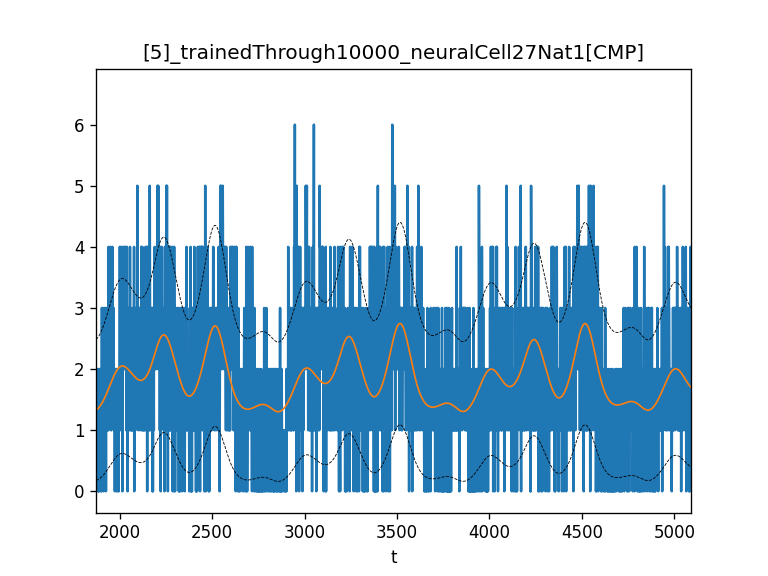

In [29]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="$\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
#     plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


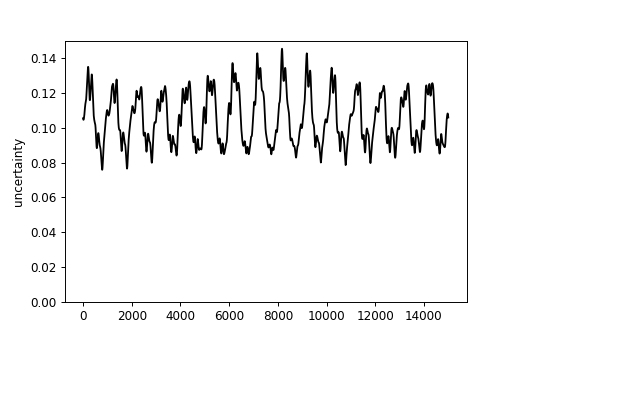

(0.0, 0.15)

In [158]:
plt.plot(std_hat, "k")
plt.ylabel("uncertainty")
plt.ylim([0, 0.15])

In [158]:
U, S, Vh = np.linalg.svd(responses, full_matrices=False)

In [160]:
cov = responses.T @ responses / (responses.shape[1] - 1)
plt.imshow(cov)
plt.title("covariance: 120 sec movie")
plt.ylabel("unit")
plt.xlabel("unit")
plt.xticks(range(0, 60 ,10))
plt.show()

<IPython.core.display.Javascript object>


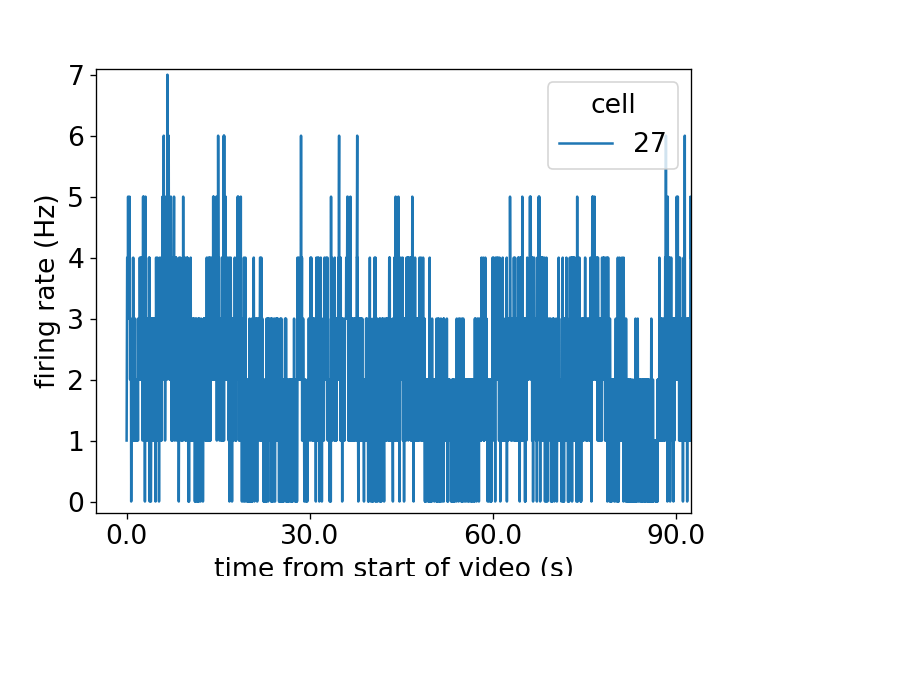

In [181]:
plt.plot(responses[:, 27])
ticks = np.linspace(0, num_bins, 11).astype(int)
plt.xticks(ticks)
ax = plt.gca()
ax.set_xticklabels(np.round(bin_edges[ticks], 1))
plt.ylabel("firing rate (Hz)")
plt.xlabel("time from start of video (s)")
plt.title("")
plt.legend(title="cell", labels=[27], loc="upper right")

In [31]:
def Z(lam, v, n=100):
    j = np.arange(n)
    return np.sum(lam**j / (factorial(j)**v))

def CMPpmf(x, lam, v, n=100):
    return lam**x / (factorial(x)**v * Z(lam, v, n=n))

def logCMPpmf(x, lam, v, n=100):
    vlog_factorial = np.vectorize(log_factorial)
    first = x * np.log(lam)
    print("first", first)
    second = v * vlog_factorial(x)
    print(second)
    return first - second - np.log(Z(lam, v, n=n))  # todo torch

def log_factorial(x):
    # log(x(x-1)(x-2)...(2)(1)) = log(x) + log(x-1) + ... + log(2) + log(1)
    return np.sum(np.log(np.arange(1, x + 1)))

<IPython.core.display.Javascript object>


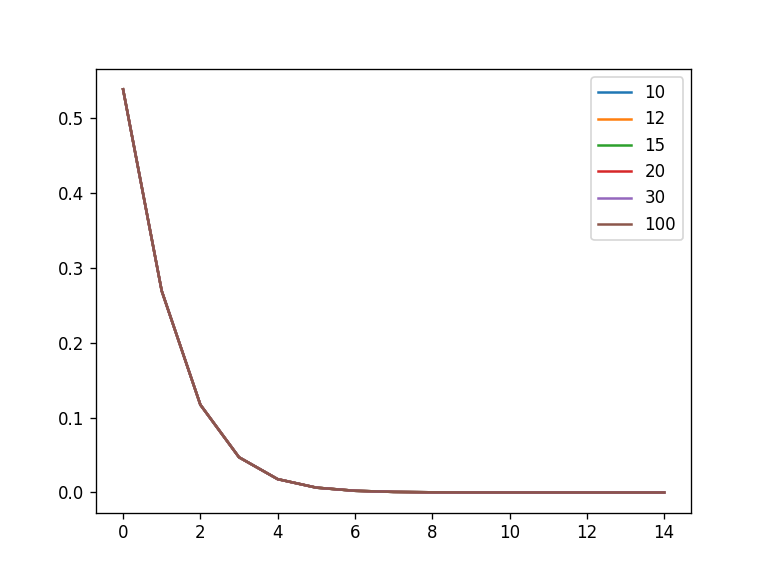

first [-0.         -0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359
 -4.15888308 -4.85203026 -5.54517744 -6.23832463 -6.93147181 -7.62461899
 -8.31776617 -9.01091335 -9.70406053]
[0.         0.         0.13862944 0.35835189 0.63561077 0.95749835
 1.31585024 1.70503227 2.12092058 2.5603655  3.02088251 3.50046157
 3.9974429  4.51043277 5.03824424]
first [-0.         -0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359
 -4.15888308 -4.85203026 -5.54517744 -6.23832463 -6.93147181 -7.62461899
 -8.31776617 -9.01091335 -9.70406053]
[0.         0.         0.13862944 0.35835189 0.63561077 0.95749835
 1.31585024 1.70503227 2.12092058 2.5603655  3.02088251 3.50046157
 3.9974429  4.51043277 5.03824424]
first [-0.         -0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359
 -4.15888308 -4.85203026 -5.54517744 -6.23832463 -6.93147181 -7.62461899
 -8.31776617 -9.01091335 -9.70406053]
[0.         0.         0.13862944 0.35835189 0.63561077 0.95749835
 1.31585024 1.70503227 2.120

In [33]:
import scipy
from scipy.special import factorial
%matplotlib notebook
plt.subplots(dpi=100)
for n in [10, 12, 15, 20, 30, 100]:
    axis = np.arange(15)
    lam = 0.5
    v = 0.2
    logpmf = logCMPpmf(axis, lam, v, n=n)
    logpmf2 = np.log(CMPpmf(axis, lam, v, n=n))
    plt.plot(np.exp(logpmf), label=str(n))
#     plt.plot(logpmf2, "--", label=str(n))
plt.legend()

In [134]:
x = 20
np.sum(np.log(np.arange(1, x)))

39.339884187199495

In [75]:
np.math.factorial(np.arange(10, dtype=np.int32))

TypeError: only size-1 arrays can be converted to Python scalars